# Implementing Customer Segmentation using RFM analysis

### import libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from operator import attrgetter
import sklearn.preprocessing as preprocessing
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import math
from sklearn.preprocessing import StandardScaler

In [2]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"

### Read Dataset

In [3]:
data = pd.read_csv(r'C:\Users\Downloads\data.csv', parse_dates=['created_at'])

In [4]:
df = data.copy()

### Prepare Data

In [5]:
df['total_basket'] = df['basket']+df['discount_cost']


In [6]:
L = ['year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter']
df = df.join(pd.concat((getattr(df['created_at'].dt, i).rename(i) for i in L), axis=1))

C:\Users\SnappMarket\AppData\Local\Temp\ipykernel_16996\2301937359.py:2: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



In [7]:
df = df[(df['discount_cost'] >= 0) & (df['basket'] > 0)]

In [8]:
df.rename(columns = {'created_at':'order_date'}, inplace = True)

In [9]:
df[['discount_cost', 'basket']] = df[['discount_cost', 'basket']].astype(float)

In [10]:
df.dayofweek.unique()

array([0, 6, 2, 5, 1, 3, 4], dtype=int64)

In [11]:
df['dayofweek'] = df['dayofweek'] + 1

In [12]:
df['order_month'] = df['order_date'].dt.to_period('M')

In [13]:
performans_date = df["order_date"].max()

In [14]:
df.dtypes

order_id                  int64
user_id                   int64
order_date       datetime64[ns]
discount_cost           float64
basket                  float64
total_basket              int64
year                      int64
month                     int64
day                       int64
dayofweek                 int64
dayofyear                 int64
weekofyear                int64
quarter                   int64
order_month           period[M]
dtype: object

In [15]:
print ("Rows     : " , df.shape[0])
print ("Columns  : " , df.shape[1])
print ("\nFeatures : \n" ,df.columns.tolist())
print ("\nUnique values :  \n", df.nunique())
print ("\nMissing values Total :  ", df.isnull().sum().values.sum())
print ("\nMissing values :  \n", df.isnull().sum())

Rows     :  29057
Columns  :  14

Features : 
 ['order_id', 'user_id', 'order_date', 'discount_cost', 'basket', 'total_basket', 'year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter', 'order_month']

Unique values :  
 order_id         29057
user_id           9985
order_date         215
discount_cost      107
basket             511
total_basket       604
year                 2
month                8
day                 31
dayofweek            7
dayofyear          213
weekofyear          32
quarter              4
order_month         10
dtype: int64

Missing values Total :   0

Missing values :  
 order_id         0
user_id          0
order_date       0
discount_cost    0
basket           0
total_basket     0
year             0
month            0
day              0
dayofweek        0
dayofyear        0
weekofyear       0
quarter          0
order_month      0
dtype: int64


In [16]:
df.shape

(29057, 14)

In [17]:
df.head(10)

,order_id,user_id,order_date,discount_cost,basket,total_basket,year,month,day,dayofweek,dayofyear,weekofyear,quarter,order_month
0,1,1,2021-04-12,10000.0,12000.0,22000,2021,4,12,1,102,15,2,2021-04
1,2,2,2021-05-09,0.0,20000.0,20000,2021,5,9,7,129,18,2,2021-05
2,3,3,2021-05-09,10000.0,14000.0,24000,2021,5,9,7,129,18,2,2021-05
3,4,4,2021-11-10,0.0,15000.0,15000,2021,11,10,3,314,45,4,2021-11
4,5,5,2021-11-10,10000.0,16000.0,26000,2021,11,10,3,314,45,4,2021-11
5,6,6,2022-01-01,0.0,10000.0,10000,2022,1,1,6,1,52,1,2022-01
6,7,7,2022-01-01,0.0,29500.0,29500,2022,1,1,6,1,52,1,2022-01
7,8,8,2022-01-01,10000.0,10000.0,20000,2022,1,1,6,1,52,1,2022-01
8,9,9,2022-01-01,0.0,5000.0,5000,2022,1,1,6,1,52,1,2022-01
9,10,10,2022-01-01,0.0,35000.0,35000,2022,1,1,6,1,52,1,2022-01


### Exploratory Data Analysis

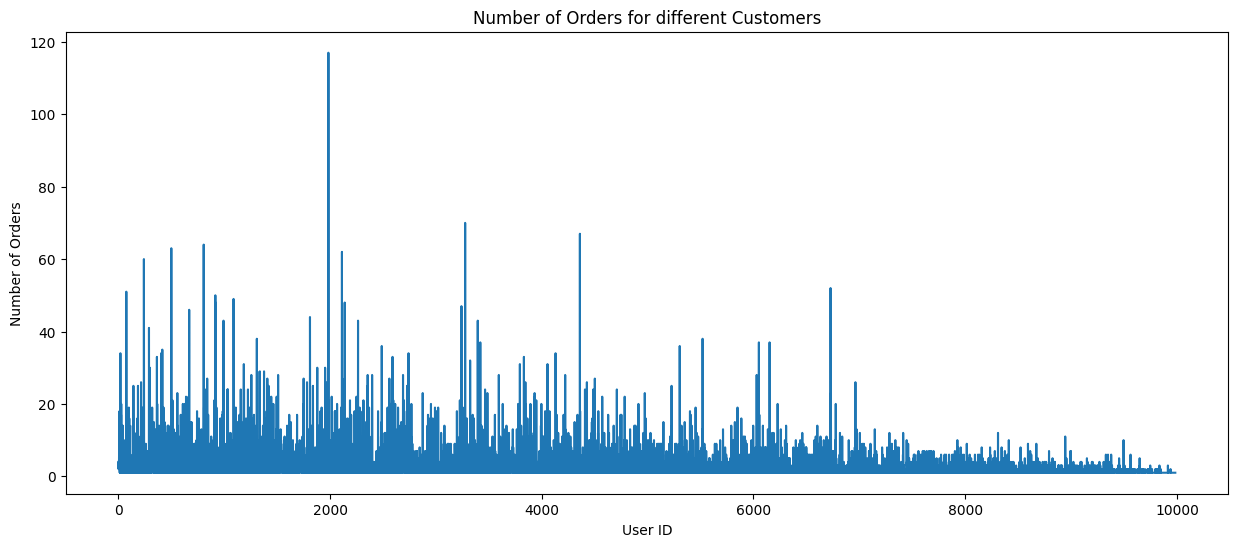

In [18]:
order = df.groupby(by=['user_id'], as_index=False)['order_id'].count()
plt.subplots(figsize=(15,6))
plt.plot(order.user_id, order.order_id)
plt.xlabel('User ID')
plt.ylabel('Number of Orders')
plt.title('Number of Orders for different Customers')
plt.show()

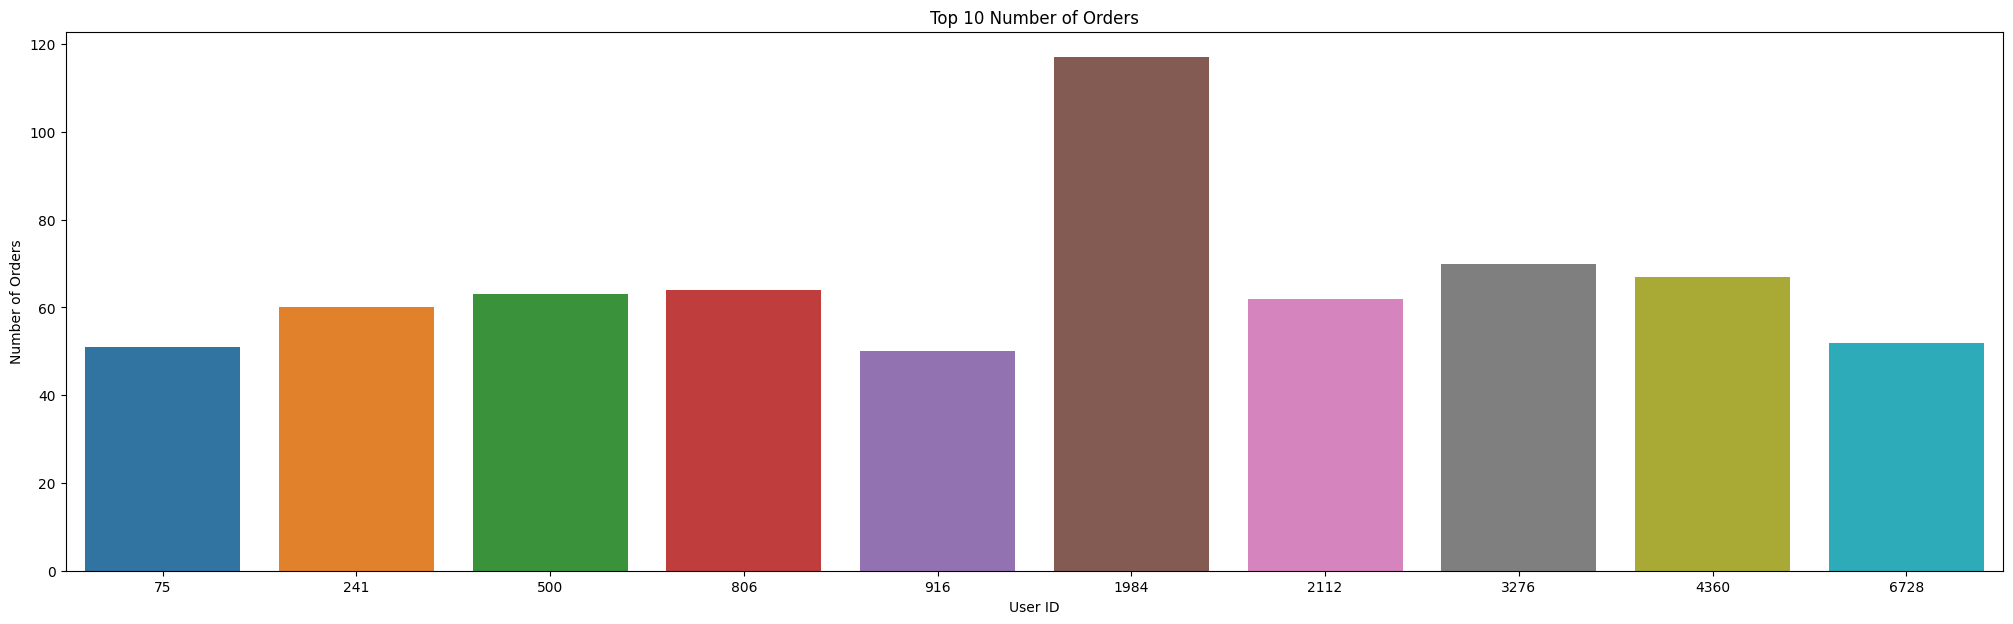

In [19]:
plt.figure(figsize=(25, 7))
sns.barplot(data= order.sort_values(by = ["order_id"], ascending=False)[:10], x="user_id", y =  "order_id")
plt.xlabel('User ID')
plt.ylabel('Number of Orders')
plt.title('Top 10 Number of Orders')
plt.show()

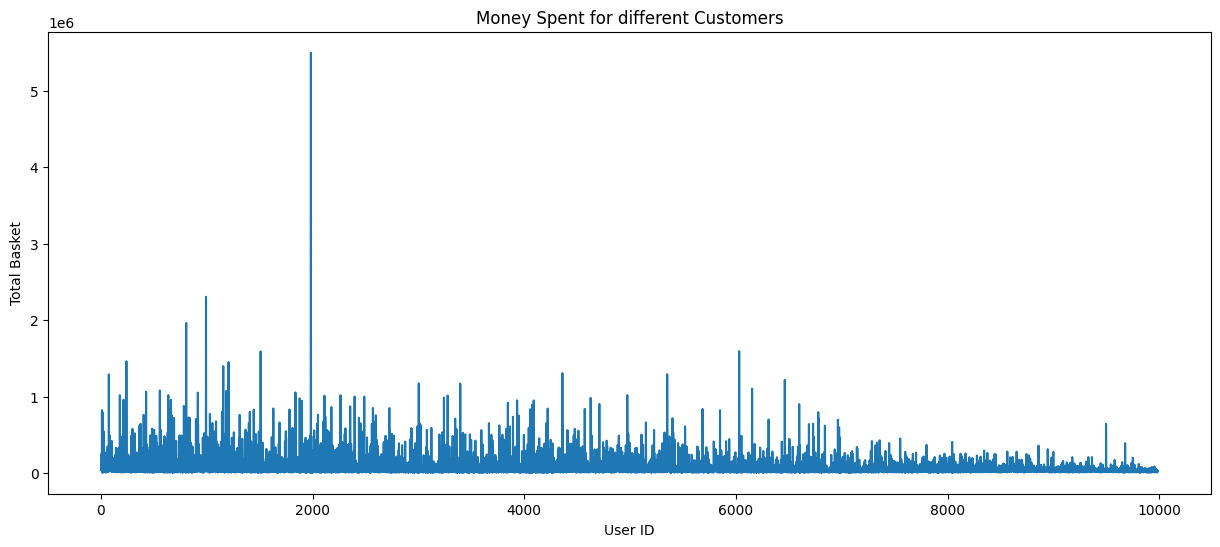

In [20]:
total_cost = df.groupby(by=['user_id'], as_index=False)['total_basket'].sum()
plt.subplots(figsize=(15,6))
plt.plot(total_cost.user_id, total_cost.total_basket)
plt.xlabel('User ID')
plt.ylabel('Total Basket')
plt.title('Money Spent for different Customers')
plt.show()

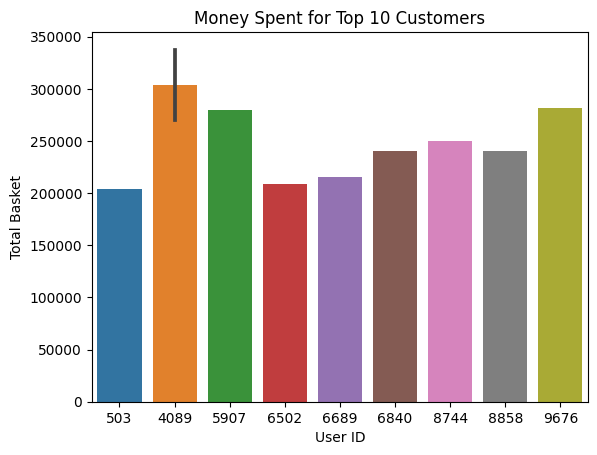

In [21]:
sns.barplot(data=df.sort_values(by = ["total_basket"], ascending=False)[:10], x="user_id", y = "total_basket")
plt.xlabel('User ID')
plt.ylabel('Total Basket')
plt.title('Money Spent for Top 10 Customers')
plt.show()

In [22]:
df.sort_values(by = ["total_basket"], ascending=False)[:10]

,order_id,user_id,order_date,discount_cost,basket,total_basket,year,month,day,dayofweek,dayofyear,weekofyear,quarter,order_month
7533,7534,4089,2022-03-26,0.0,337500.0,337500,2022,3,26,6,85,12,1,2022-03
28060,28061,9676,2022-07-27,0.0,282000.0,282000,2022,7,27,3,208,30,3,2022-07
12864,12865,5907,2022-05-01,0.0,280000.0,280000,2022,5,1,7,121,17,2,2022-05
11664,11665,4089,2022-04-24,0.0,270000.0,270000,2022,4,24,7,114,16,2,2022-04
23633,23634,8744,2022-07-05,0.0,250000.0,250000,2022,7,5,2,186,27,3,2022-07
22571,22572,6840,2022-06-30,0.0,240500.0,240500,2022,6,30,4,181,26,2,2022-06
24061,24062,8858,2022-07-07,0.0,240000.0,240000,2022,7,7,4,188,27,3,2022-07
18908,18909,6689,2022-06-10,0.0,215000.0,215000,2022,6,10,5,161,23,2,2022-06
25496,25497,6502,2022-07-15,6400.0,202000.0,208400,2022,7,15,5,196,28,3,2022-07
1726,1727,503,2022-01-28,0.0,204000.0,204000,2022,1,28,5,28,4,1,2022-01


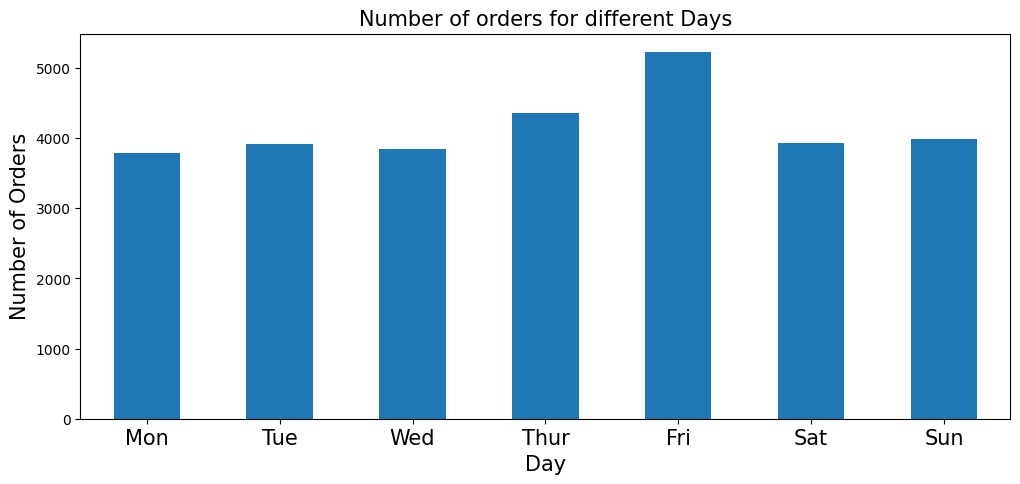

In [23]:
ax = df.groupby('dayofweek')['order_id'].count().sort_index().plot(kind ='bar',figsize=(12,5))
ax.set_xlabel('Day',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Days',fontsize=15)
ax.set_xticklabels(('Mon','Tue','Wed','Thur','Fri', 'Sat', 'Sun'), rotation='horizontal', fontsize=15)
plt.show()

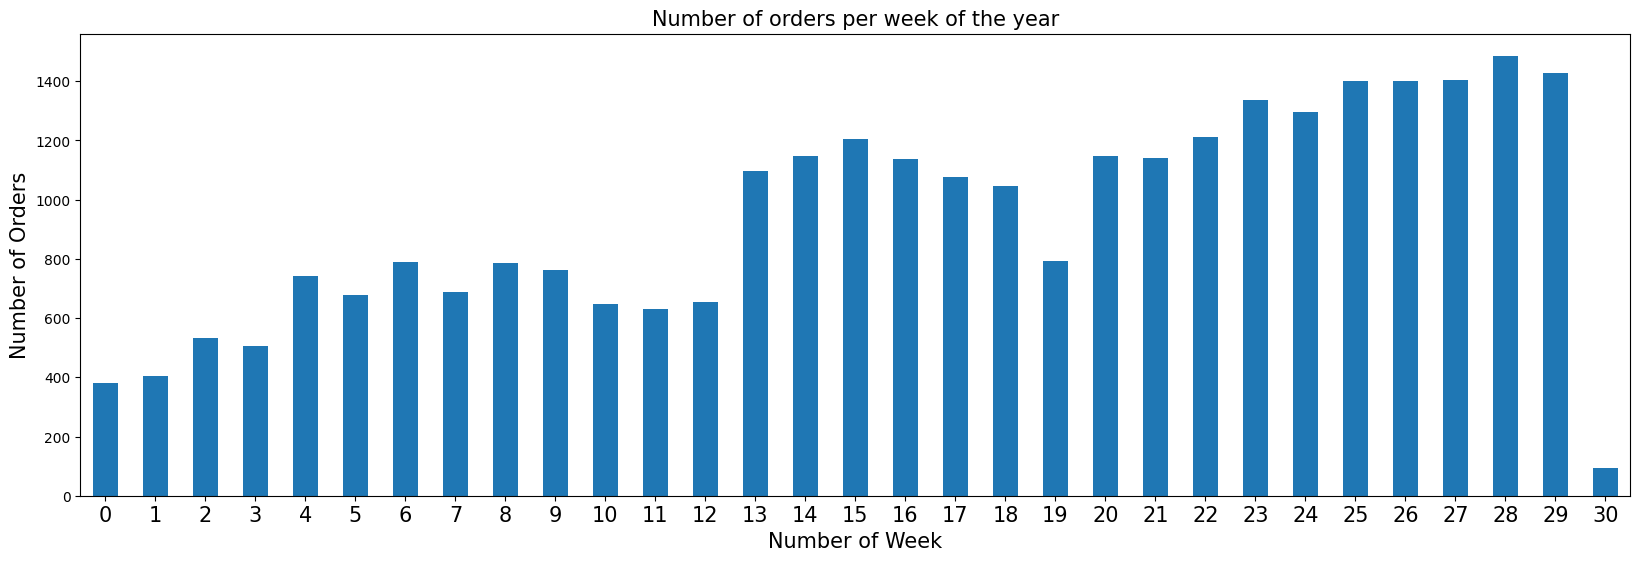

In [24]:
ax = df[df['year']==2022].groupby('weekofyear')['order_id'].count().sort_index().plot(kind = 'bar',figsize=(20,6))
ax.set_xlabel('Number of Week',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders per week of the year',fontsize=15)
ax.set_xticklabels(range(0,31), rotation='horizontal', fontsize=15)
plt.show()

### RFM Model Implementation 

In [25]:
rfm_df = df.groupby("user_id").agg \
                                    ({"order_date" : lambda order_date :(performans_date - order_date.max()).days,  
                                     "order_id" : lambda order_id: order_id.nunique(),  
                                     "total_basket":  lambda total_basket: total_basket.sum()}).reset_index(drop=False)

In [26]:
rfm_df.columns = ['user_id','recency', 'frequency', 'monetary']
rfm_df

,user_id,recency,frequency,monetary
0,1,83,4,40200
1,2,57,2,61000
2,3,13,4,73500
3,4,113,3,69600
4,5,194,2,49500
...,...,...,...,...
9980,9981,0,1,34000
9981,9982,0,1,30000
9982,9983,0,1,21000
9983,9984,0,1,22000


In [27]:
rfm_df["Recency_Score"]  = pd.qcut(rfm_df['recency'], 5, [5, 4, 3, 2, 1])
rfm_df["Frequency_Score"]  = pd.qcut(rfm_df['frequency'].rank(method="first"), 5, [1, 2, 3, 4, 5])
rfm_df["Monetary_Score"]  = pd.qcut(rfm_df['monetary'], 5, [1, 2, 3, 4, 5])

In [28]:
rfm_df["rfm_segment"] = (rfm_df['Recency_Score'].astype(str) +
                    rfm_df['Frequency_Score'].astype(str))

rfm_df.head() 

,user_id,recency,frequency,monetary,Recency_Score,Frequency_Score,Monetary_Score,rfm_segment
0,1,83,4,40200,2,4,3,24
1,2,57,2,61000,3,3,4,33
2,3,13,4,73500,5,4,4,54
3,4,113,3,69600,2,4,4,24
4,5,194,2,49500,1,3,4,13


In [29]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}
rfm_df['rfm_segment'] = rfm_df['rfm_segment'].replace(seg_map, regex=True)
rfm_df.head()

,user_id,recency,frequency,monetary,Recency_Score,Frequency_Score,Monetary_Score,rfm_segment
0,1,83,4,40200,2,4,3,at_Risk
1,2,57,2,61000,3,3,4,need_attention
2,3,13,4,73500,5,4,4,champions
3,4,113,3,69600,2,4,4,at_Risk
4,5,194,2,49500,1,3,4,at_Risk


In [30]:
rfm_df.groupby('rfm_segment').agg({"user_id":"count"}).sort_values("user_id",ascending=False)


,user_id
rfm_segment,
hibernating,3010
loyal_customers,1880
potential_loyalists,1537
champions,1460
about_to_sleep,984
at_Risk,815
cant_loose,163
need_attention,136


<Axes: ylabel='rfm_segment'>

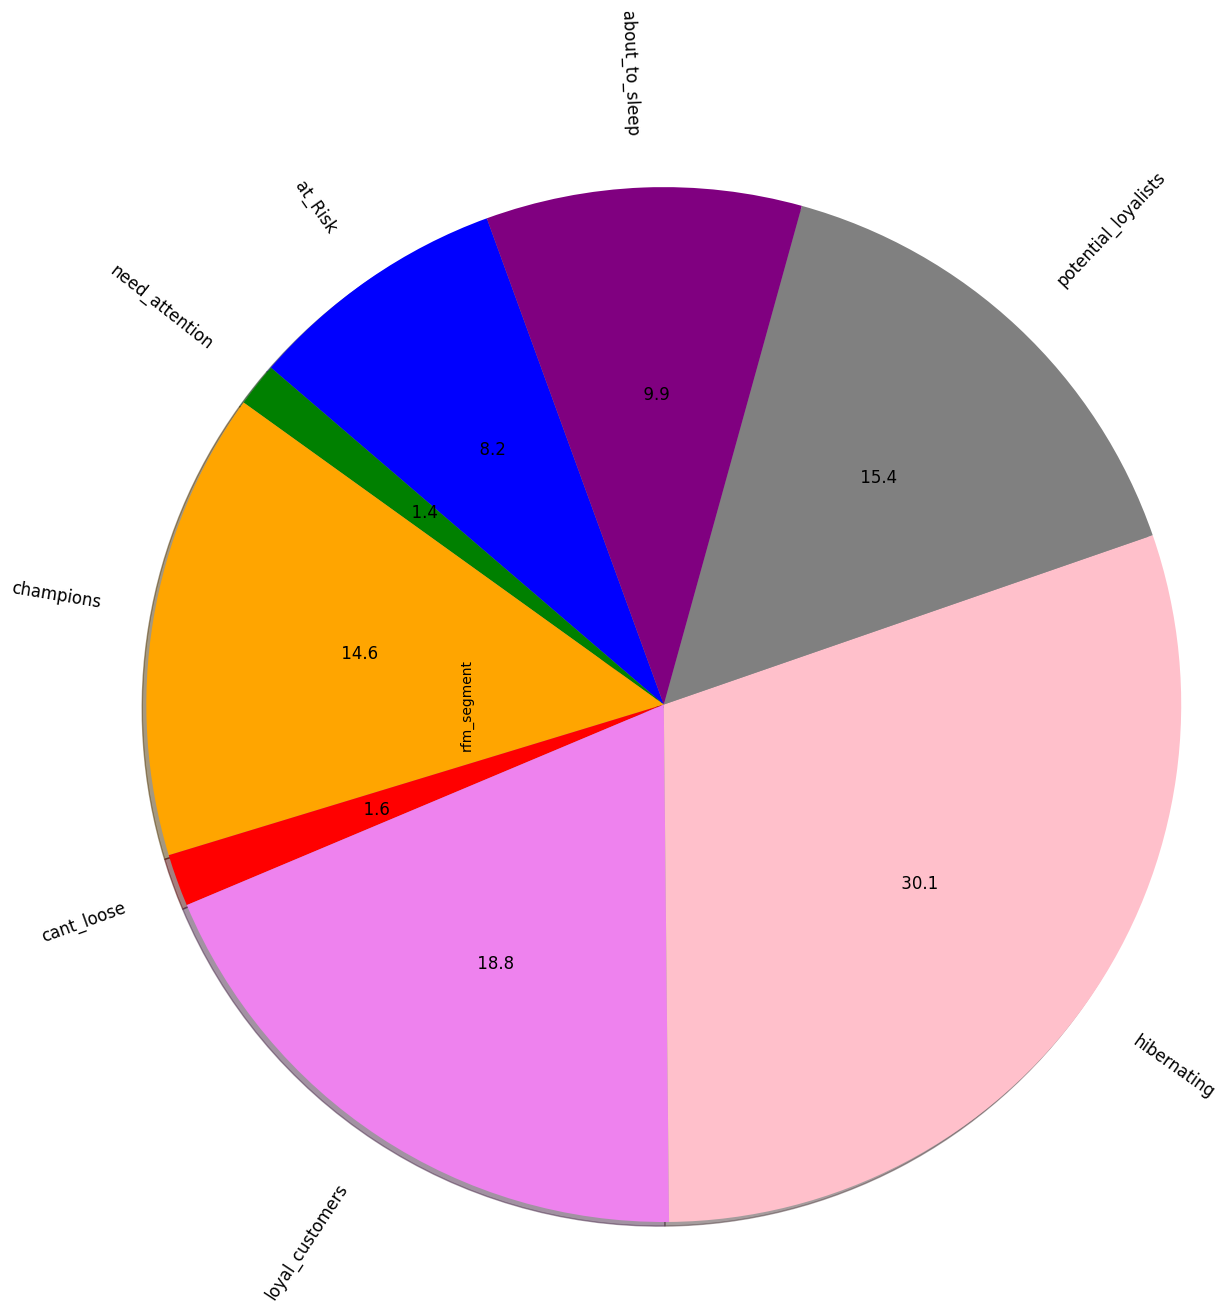

In [31]:
colors  = ("blue", "green", "orange", "red", "violet", "pink", "grey", "purple")
rfm_df["rfm_segment"].value_counts(sort=False).plot.pie(colors=colors,
                                                 textprops={'fontsize': 12}, 
                                                 autopct = '%5.1f',
                                                 startangle= 110, 
                                                 radius =3.5, 
                                                 rotatelabels=True,
                                                 shadow = True, 
                                                 )

In [32]:
rfm_df[["rfm_segment","recency", "frequency", "monetary"]].groupby("rfm_segment").agg(["mean", "count","sum"])

recency               frequency               \
                           mean count     sum      mean count    sum   
rfm_segment                                                            
about_to_sleep        60.111789   984   59150  1.000000   984    984   
at_Risk              127.303067   815  103752  2.320245   815   1891   
cant_loose           112.766871   163   18381  6.171779   163   1006   
champions              5.431507  1460    7930  7.832192  1460  11435   
hibernating          145.274086  3010  437275  1.000000  3010   3010   
loyal_customers       38.217553  1880   71849  4.751064  1880   8932   
need_attention        49.735294   136    6764  1.470588   136    200   
potential_loyalists   18.921275  1537   29082  1.040338  1537   1599   

                          monetary                   
                              mean count        sum  
rfm_segment                                          
about_to_sleep        27208.434959   984   26773100  
at_Risk               56789.202454   815   46283200  
cant_loose           137861.901840   163   22471490  
champions            215667.196575  1460  314874107  
hibernating           24873.684385  3010   74869790  
loyal_customers      126402.946809  1880  237637540  
need_attention        38166.250000   136    5190610  
potential_loyalists   32486.387768  1537   49931578

In [33]:
rfm_df['recency_log'] = rfm_df['recency'][rfm_df['recency']!=0].apply(math.log)
rfm_df['frequency_log'] = rfm_df['frequency'].apply(math.log)
rfm_df['monetary_log'] = rfm_df['monetary'].apply(math.log)
feature_vector = ['monetary_log', 'recency_log','frequency_log']
X_subset = rfm_df[feature_vector] 
scaler = preprocessing.StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)
pd.DataFrame(X_scaled, columns=X_subset.columns).describe().T

,count,mean,std,min,25%,50%,75%,max
monetary_log,9985.0,-3.700373e-16,1.000050,-2.186793,-0.686531,-0.187852,0.595075,4.904003
recency_log,9801.0,4.407815e-16,1.000051,-2.912490,-0.589515,0.236092,0.812683,1.237491
frequency_log,9985.0,1.138576e-16,1.000050,-0.738274,-0.738274,-0.738274,0.600236,5.063789


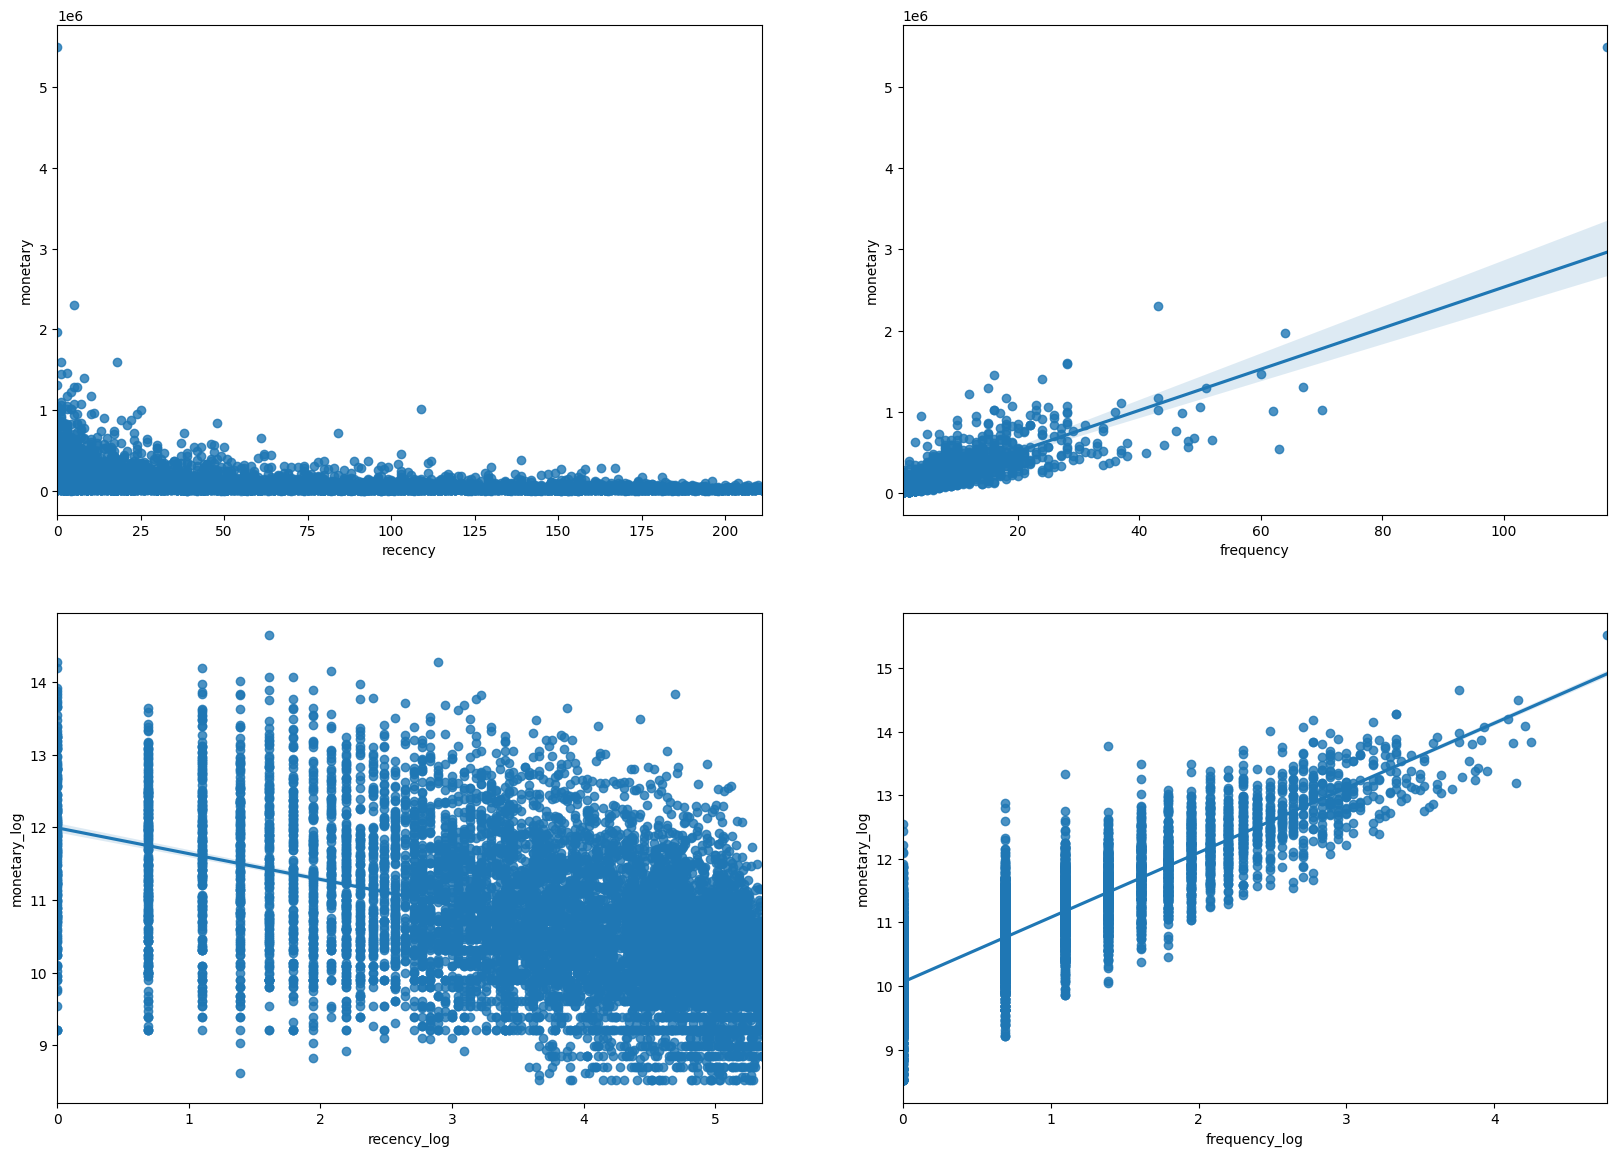

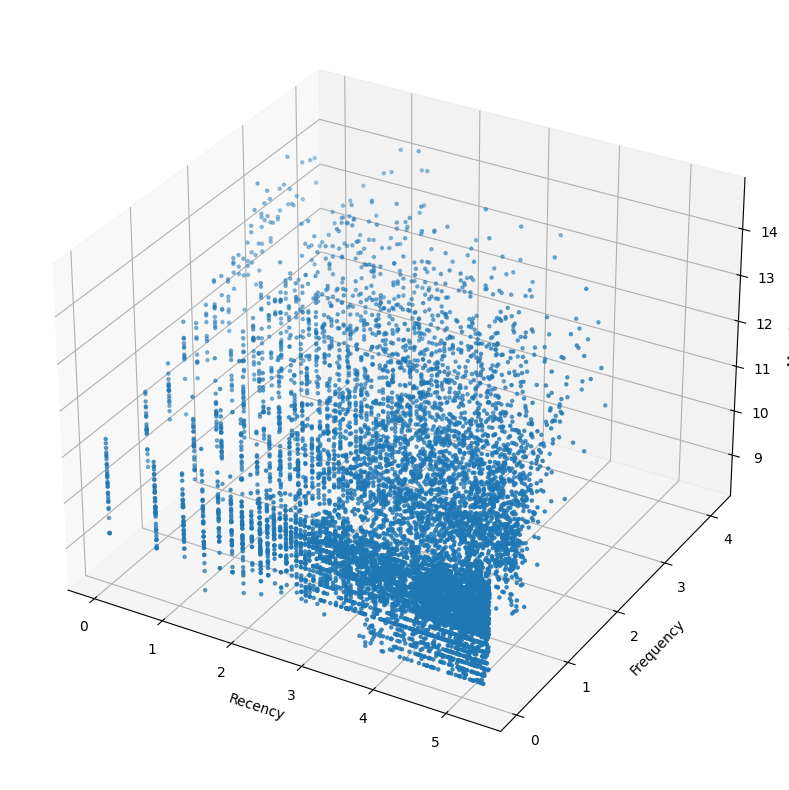

In [34]:
fig = plt.figure(figsize=(20,14))
f1 = fig.add_subplot(221); sns.regplot(x='recency', y='monetary', data=rfm_df)
f1 = fig.add_subplot(222); sns.regplot(x='frequency', y='monetary', data=rfm_df)
f1 = fig.add_subplot(223); sns.regplot(x='recency_log', y='monetary_log', data=rfm_df)
f1 = fig.add_subplot(224); sns.regplot(x='frequency_log', y='monetary_log', data=rfm_df)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

xs =rfm_df.recency_log
ys = rfm_df.frequency_log
zs = rfm_df.monetary_log
ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()

C:\Users\SnappMarket\AppData\Local\Temp\ipykernel_16996\3805053264.py:3: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.

c:\Users\SnappMarket\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\Users\SnappMarket\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\Users\SnappMarket\AppData\Local\Prog

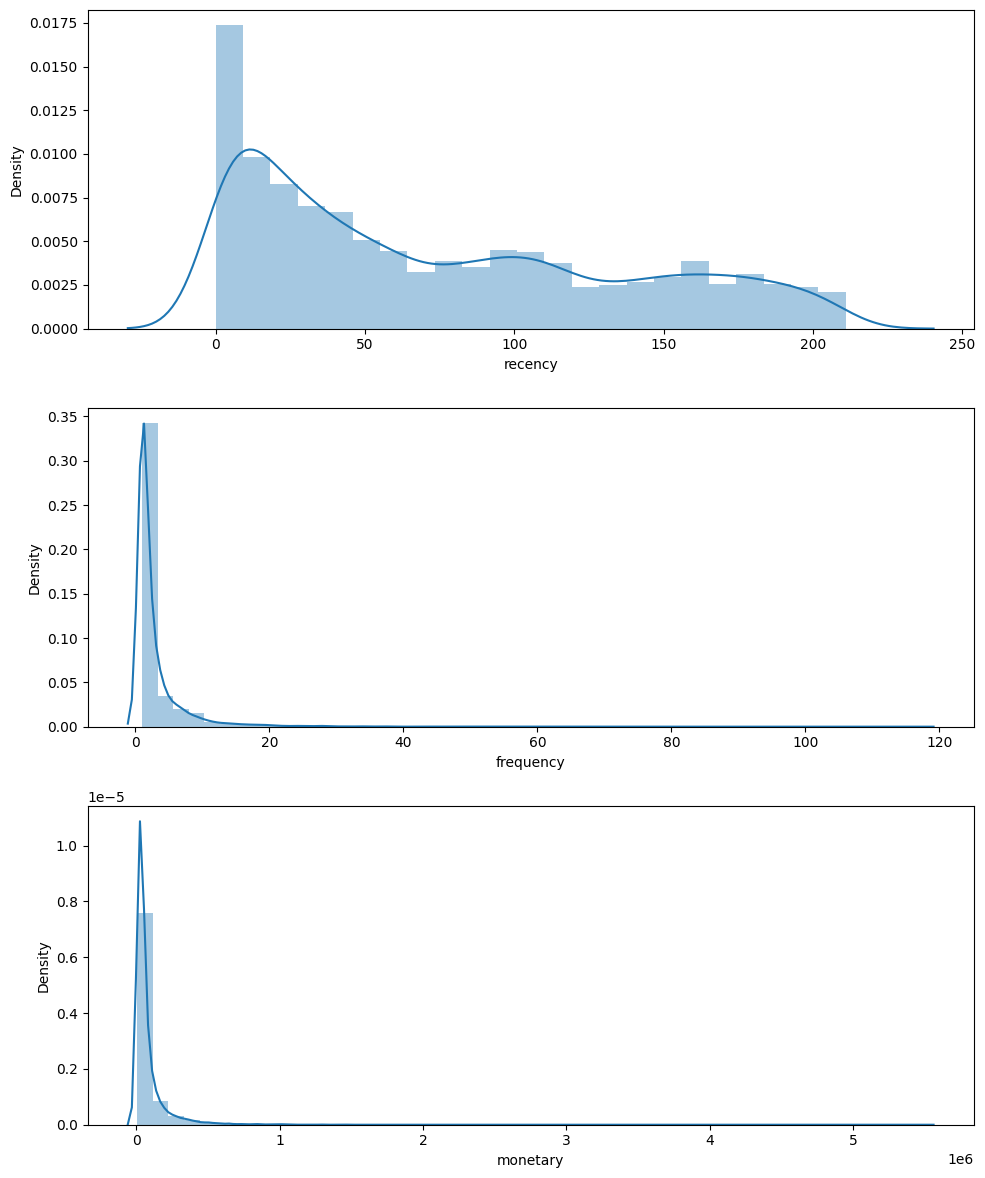

In [35]:
# plot the distribution of RFM values
f,ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); sns.distplot(rfm_df.recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm_df.frequency, label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm_df.monetary, label = 'Monetary')
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

In [36]:
rfm_log = rfm_df[['recency', 'frequency', 'monetary']].apply(np.log, axis = 1).round(3)
rfm_log

,recency,frequency,monetary
0,4.419,1.386,10.602
1,4.043,0.693,11.019
2,2.565,1.386,11.205
3,4.727,1.099,11.151
4,5.268,0.693,10.810
...,...,...,...
9980,-inf,0.000,10.434
9981,-inf,0.000,10.309
9982,-inf,0.000,9.952
9983,-inf,0.000,9.999


In [37]:
np.isfinite(rfm_log).sum()

recency      9801
frequency    9985
monetary     9985
dtype: int64

In [38]:
rfm_log.replace([np.inf, -np.inf], np.nan, inplace=True)
rfm_log.isna().sum()

recency      184
frequency      0
monetary       0
dtype: int64

In [39]:
rfm_log.dropna(subset=['recency'], how="all", inplace=True)
rfm_log

,recency,frequency,monetary
0,4.419,1.386,10.602
1,4.043,0.693,11.019
2,2.565,1.386,11.205
3,4.727,1.099,11.151
4,5.268,0.693,10.810
...,...,...,...
9943,0.000,0.000,10.714
9944,0.000,0.000,10.463
9945,0.000,0.000,10.933
9946,0.000,0.000,9.547


C:\Users\SnappMarket\AppData\Local\Temp\ipykernel_16996\2253304312.py:3: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.

c:\Users\SnappMarket\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\Users\SnappMarket\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\Users\SnappMarket\AppData\Local\Prog

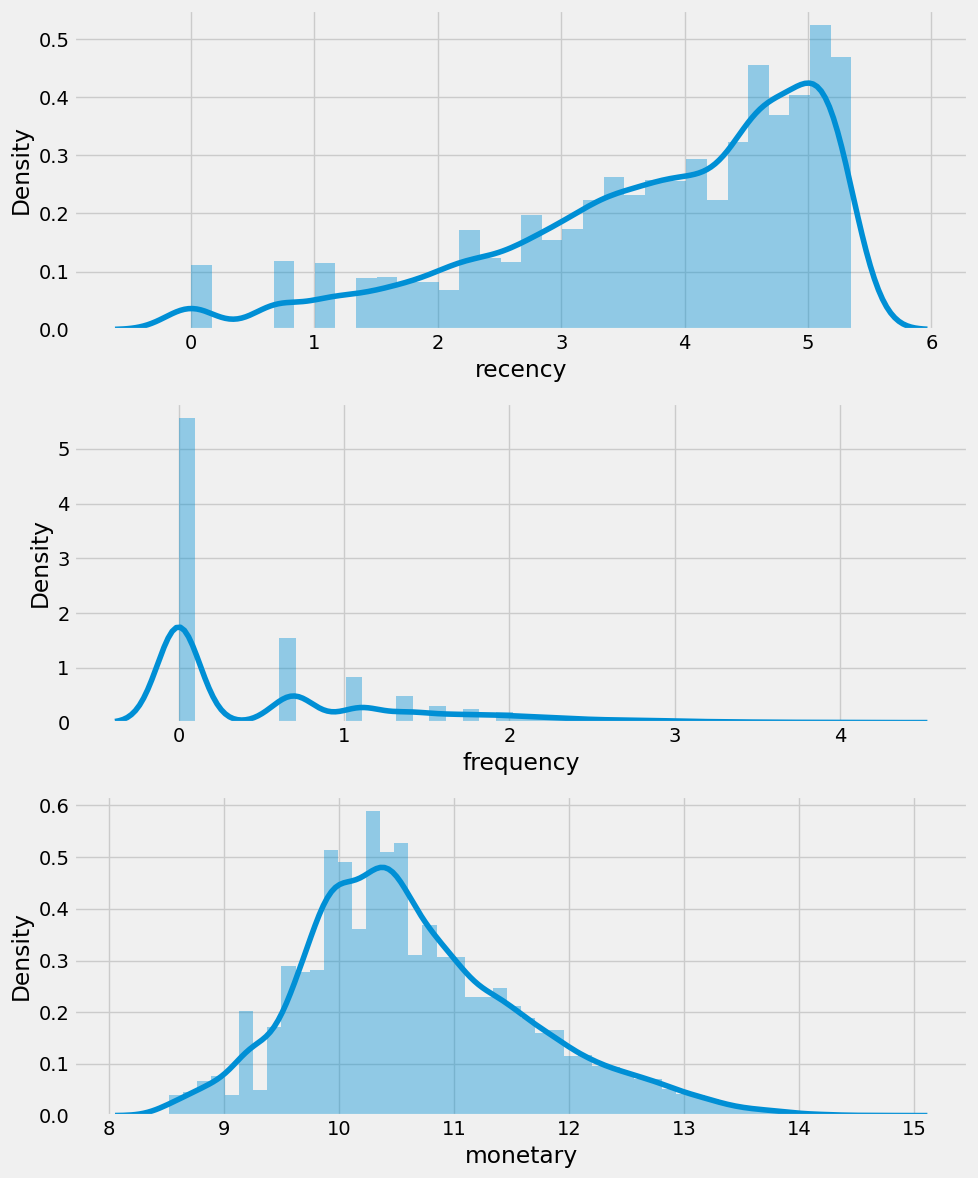

In [40]:
# plot the distribution of RFM values
f,ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); sns.distplot(rfm_log.recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm_log.frequency, label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm_log.monetary, label = 'Monetary')
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

In [41]:
rfm_df['RFM_Score'] = rfm_df[['Recency_Score',	'Frequency_Score',	'Monetary_Score']].sum(axis=1).astype(float)
rfm_df['RFM_Score'].describe()

count    9985.000000
mean        8.964647
std         3.709484
min         3.000000
25%         6.000000
50%         9.000000
75%        12.000000
max        15.000000
Name: RFM_Score, dtype: float64

In [42]:
def segments(rfm_df):
    if rfm_df['RFM_Score'] > 9 :
        return 'Gold'
    elif (rfm_df['RFM_Score'] > 5) and (rfm_df['RFM_Score'] <= 9 ):
        return 'Sliver'
    else:  
        return 'Bronze'

In [43]:
rfm_df['Segments'] = rfm_df.apply(segments,axis=1)
rfm_df

,user_id,recency,frequency,monetary,Recency_Score,Frequency_Score,Monetary_Score,rfm_segment,recency_log,frequency_log,monetary_log,RFM_Score,Segments
0,1,83,4,40200,2,4,3,at_Risk,4.418841,1.386294,10.601622,9.0,Sliver
1,2,57,2,61000,3,3,4,need_attention,4.043051,0.693147,11.018629,10.0,Gold
2,3,13,4,73500,5,4,4,champions,2.564949,1.386294,11.205041,13.0,Gold
3,4,113,3,69600,2,4,4,at_Risk,4.727388,1.098612,11.150520,10.0,Gold
4,5,194,2,49500,1,3,4,at_Risk,5.267858,0.693147,10.809728,8.0,Sliver
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9980,9981,0,1,34000,5,3,3,potential_loyalists,NaN,0.000000,10.434116,11.0,Gold
9981,9982,0,1,30000,5,3,2,potential_loyalists,NaN,0.000000,10.308953,10.0,Gold
9982,9983,0,1,21000,5,3,2,potential_loyalists,NaN,0.000000,9.952278,10.0,Gold
9983,9984,0,1,22000,5,3,2,potential_loyalists,NaN,0.000000,9.998798,10.0,Gold


In [44]:
rfm_df.groupby('Segments').agg({'recency':'mean','frequency':'mean',
                                    'monetary':['mean','count']}).round(1)

recency frequency  monetary      
            mean      mean      mean count
Segments                                  
Bronze     155.7       1.0   20552.8  2309
Gold        30.6       5.0  139003.1  4577
Sliver      75.7       1.2   30447.8  3099

### KMean Implementaion

In [45]:
# normalize the data
normalizer = StandardScaler()
rfm_normalized = normalizer.fit_transform(rfm_df[['recency', 'frequency', 'monetary']])


In [46]:
ks = range(1,15)
inertias=[]
for k in ks :
    kc = KMeans(n_clusters=k,random_state=1)
    kc.fit(rfm_normalized)
    inertias.append(kc.inertia_)

c:\Users\SnappMarket\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\SnappMarket\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\SnappMarket\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\SnappMarket\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicit

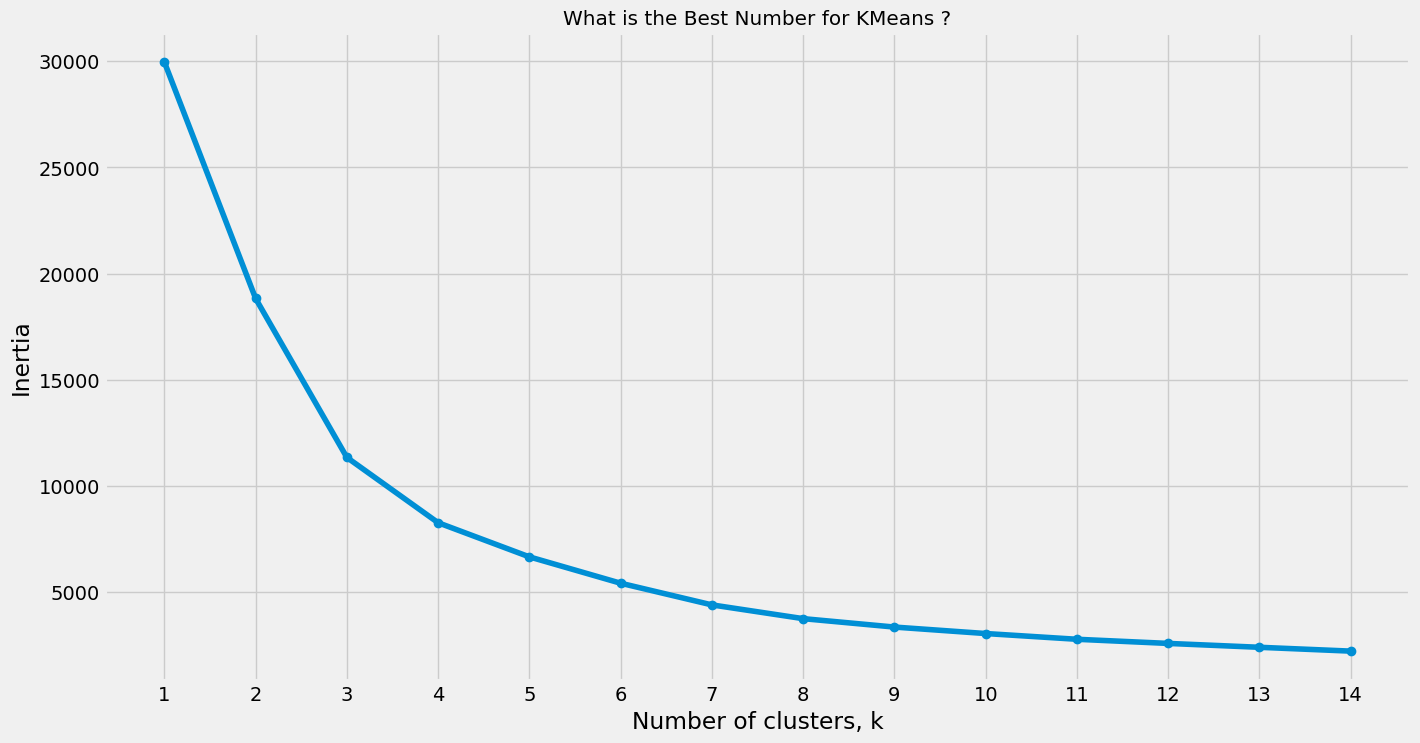

In [47]:
f, ax = plt.subplots(figsize=(15, 8))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.style.use('ggplot')
plt.title('What is the Best Number for KMeans ?')
plt.show()

In [48]:
# fit the kmeans model
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(rfm_normalized)

c:\Users\SnappMarket\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(n_clusters=4, random_state=42)

In [49]:
# add the cluster labels to the original data
rfm_df['Cluster'] = kmeans.labels_

In [50]:
# view the segmentation results
rfm_df.groupby('Cluster')['recency','frequency','monetary'].mean()

C:\Users\SnappMarket\AppData\Local\Temp\ipykernel_16996\1709051089.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,recency,frequency,monetary
Cluster,,,
0,19.057239,10.456790,297619.193042
1,34.596674,2.161595,56290.870724
2,7.111111,30.907407,872073.166667
3,144.352909,1.343708,32701.979702


In [51]:
rfm_df['Cluster'].value_counts()

1    5291
3    3695
0     891
2     108
Name: Cluster, dtype: int64

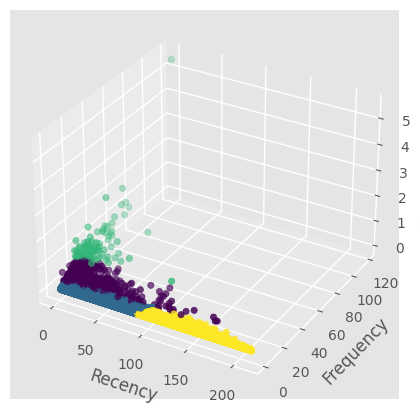

In [52]:
# visualize the segmentation results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = rfm_df['recency']
y = rfm_df['frequency']
z = rfm_df['monetary']
c = rfm_df['Cluster']

ax.scatter(x, y, z, c=c)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value')

plt.show()

<Axes: ylabel='Cluster'>

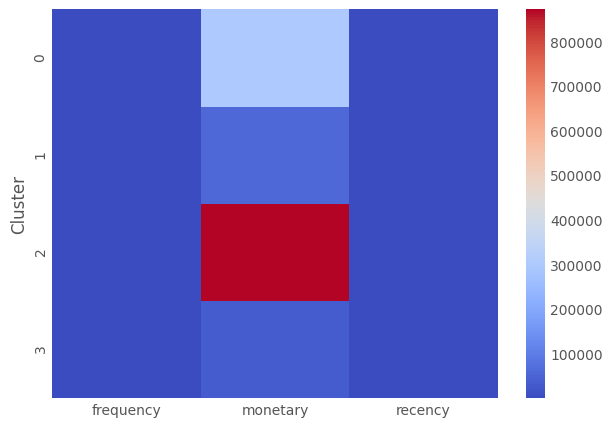

In [53]:
# create a heatmap
heatmap_data = rfm_df.pivot_table(index='Cluster', values=['recency', 'frequency', 'monetary'], aggfunc='mean')
sns.heatmap(heatmap_data, cmap='coolwarm')

<Axes: >

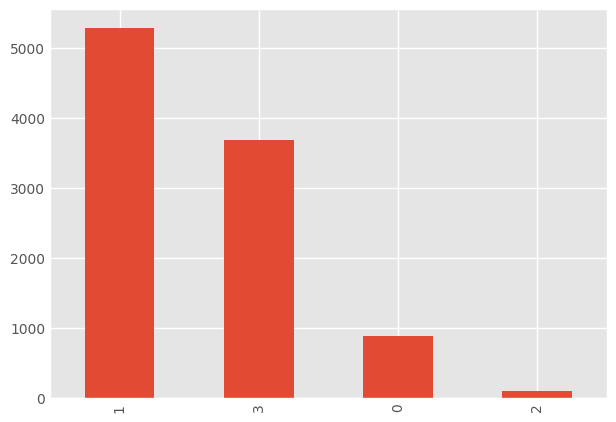

In [54]:
# create a bar chart
rfm_df['Cluster'].value_counts().plot(kind='bar')

In [55]:
# create a radar chart
radar_data = rfm_df.groupby('Cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean'
}).reset_index()

fig = go.Figure()

for i in range(len(radar_data)):
    fig.add_trace(go.Scatterpolar(
        r=[radar_data.iloc[i,1], radar_data.iloc[i,2], radar_data.iloc[i,3]],
        theta=['Recency', 'Frequency', 'MonetaryValue'],
        fill='toself',
        name=f'Cluster {radar_data.iloc[i,0]+1}'
    ))

In [56]:
display(fig)